In [8]:
import diffmaps
import h5py
import glob
import pylab as pyl
import numpy as np
from scipy.linalg import svd
from scipy.misc import imresize
from scipy.spatial.distance import pdist, squareform

In [9]:
DATADIR = '/Users/mtrigo/Documents/cryoEM/randomrot1D/'

In [10]:
def dm_affinity_matrix(data, b, sigma2, alph):
    n, D = np.shape(data)
    
    xdist2  = squareform(pdist(data))
    
    ids     = np.argsort(xdist2, axis=0)
    xdsts2  = np.sort(xdist2, axis=0)  # sort columns of distance matrix
    xdsts2  = xdsts2[0:b,:]          # keep only `b` nearest neighbors
    ids     = ids[0:b, :]

    # build weight matrix and transition probability matrix
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(b):
            K[i, ids[j,i]] = np.exp( -xdsts2[j,i]**2/sigma2 )

    K = np.maximum(K, K.transpose()) # make it symmetric
    logK = np.log(np.sum(K.flatten())) # for diagnosing epsilon

    Q = np.power(np.sum(K, axis=1), alph)
    W = K/Q/Q[:,np.newaxis]

    Q = np.sum(W, axis=1)

    W = W/Q

    return W


In [48]:
files = glob.glob(DATADIR + "*defocus0.5*.h5")

def resize_pages(arr, newsize):
    n = arr.shape[0]
    data = np.zeros((n, newsize[0], newsize[1]))
    for i in range(n):
        data[i] = imresize(arr[i], newsize)
    return data
    
def get_data_from_h5(filepattern, newsize):
    data = None
    angles=None
    for fn in glob.glob(filepattern):
        print(fn)
        f = h5py.File(fn,'r')
        tmpdata = f['data'][()]
        tmpangles=f['coordinates'][()]
        if len(newsize) != 0:
            tmpdata = resize_pages(tmpdata, newsize)
        if data is None:
            data = tmpdata
            angles=tmpangles
        else:
            data = np.concatenate((data, tmpdata), axis=0)
            angles=np.concatenate((angles, tmpangles))
        f.close()
    return data, angles

In [59]:
data,angles = get_data_from_h5(DATADIR+"*defocus0.5*", (256, 256))
angles=angles[:,3]

/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy4_defocus0.5_no_noise.h5
/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy3_defocus0.5_no_noise.h5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  import sys


/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy9_defocus0.5_no_noise.h5
/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy0_defocus0.5_no_noise.h5
/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy7_defocus0.5_no_noise.h5
/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy6_defocus0.5_no_noise.h5
/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy1_defocus0.5_no_noise.h5
/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy8_defocus0.5_no_noise.h5
/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy2_defocus0.5_no_noise.h5
/Users/mtrigo/Documents/cryoEM/randomrot1D/4v6x_randomrot_copy5_defocus0.5_no_noise.h5


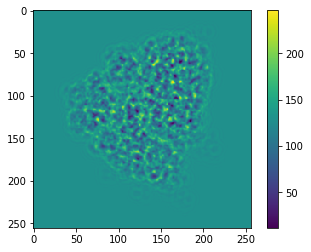

In [21]:
pyl.imshow(data[10])
pyl.colorbar()

In [15]:
shp=data.shape
datar = data.reshape(shp[0], shp[1]*shp[2])
datar.shape

(480, 65536)

In [96]:
## define the parameters for the DM
b = 150
sigma2 = 6e6
alpha = 1

In [97]:
W = dm_affinity_matrix(datar, b, sigma2, alpha)

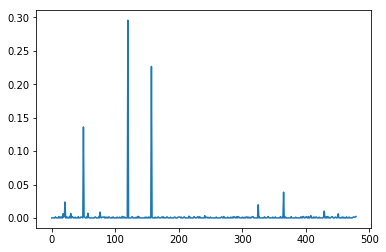

In [98]:
pyl.plot(W[:,120])

In [99]:
U,s,V = svd(W,full_matrices=False)
U = U/U[:,0]

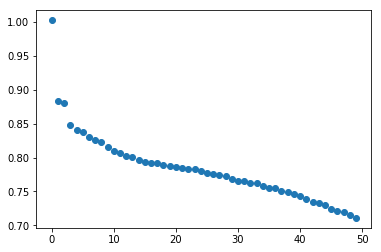

In [100]:
# pyl.plot(np.log(s),'o')
pyl.plot(s[0:50],'o')

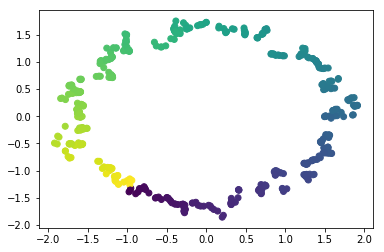

In [101]:
ii1=1
ii2=2
pyl.scatter(U[:,ii1], U[:,ii2], c=angles)